In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('all_data/dataset.csv')
df['path'] = './all_data/' + df['path']
df.head()

,path,hotdog,banana
0,./all_data/downloads/ae ae banana/19.41_2_colo...,0,1
1,./all_data/data/chili-dog/649.jpe,1,0
2,./all_data/data/banana/275.jpe,0,1
3,./all_data/insta_data/hotdogger/60557450_24223...,0,0
4,./all_data/downloads/banana hotdog/206.Copy-of...,1,0


In [3]:
import albumentations as A
import albumentations.augmentations.functional as F

import cv2

import random

class PercentageCrop(A.core.transforms_interface.DualTransform):
    """Crop a square random part of the input by percentage and rescale it to some size.

    Args:
        min_max_height ((int, int)): crop size limits.
        height (int): height after crop and resize.
        width (int): width after crop and resize.
        w2h_ratio (float): aspect ratio of crop.
        interpolation (OpenCV flag): flag that is used to specify the interpolation algorithm. Should be one of:
            cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4.
            Default: cv2.INTER_LINEAR.
        p (float): probability of applying the transform. Default: 1.

    Targets:
        image, mask, bboxes, keypoints

    Image types:
        uint8, float32
    """

    def __init__(self, height, width, h_per=0.9, w2h_ratio=1., height_per_delta=0.05, interpolation=cv2.INTER_LINEAR,
                 always_apply=False, p=1.0):
        super(PercentageCrop, self).__init__(always_apply, p)
        self.height = height
        self.width = width
        self.interpolation = interpolation
        self.height_per_delta = height_per_delta
        self.w2h_ratio = w2h_ratio
        self.h_per = h_per

    def apply(self, img, crop_height=0, crop_width=0, h_start=0, w_start=0, interpolation=cv2.INTER_LINEAR, **params):
        h, w, c = img.shape
        h = min(h, w)
        crop_height = random.randint(
            int(h * (self.h_per - self.height_per_delta)),
            int(h * (self.h_per + self.height_per_delta)),
        )
        crop_width = int(crop_height * self.w2h_ratio)
        h_start = random.random()
        w_start = random.random()
        while h_start > self.h_per - self.height_per_delta:
            h_start = random.random()
        while w_start > self.h_per - self.height_per_delta:
            w_start = random.random()
        
        
        crop = F.random_crop(img, crop_height, crop_width, h_start, w_start)
        return F.resize(crop, self.height, self.width, interpolation)

    def get_params(self):
        mx_dim = max(self.height, self.width)
        crop_height = random.randint(
            int(mx_dim * (self.h_per - self.height_per_delta)),
            int(mx_dim * (self.h_per + self.height_per_delta)),
        )
        return {'h_start': random.random(),
                'w_start': random.random(),
                'crop_height': crop_height,
                'crop_width': int(crop_height * self.w2h_ratio)}

    def apply_to_bbox(self, bbox, crop_height=0, crop_width=0, h_start=0, w_start=0, rows=0, cols=0, **params):
        return F.bbox_random_crop(bbox, crop_height, crop_width, h_start, w_start, rows, cols)

    def apply_to_keypoint(self, keypoint, crop_height=0, crop_width=0, h_start=0, w_start=0, rows=0, cols=0, **params):
        keypoint = F.keypoint_random_crop(keypoint, crop_height, crop_width, h_start, w_start, rows, cols)
        scale_x = self.width / crop_height
        scale_y = self.height / crop_height
        keypoint = F.keypoint_scale(keypoint, scale_x, scale_y)
        return keypoint

    def get_transform_init_args_names(self):
        return ('height', 'width', 'w2h_ratio', 'interpolation')


In [4]:
def strong_aug(p=.5):
    return A.Compose([
        A.Flip(p=0.65),
        A.HorizontalFlip(p=0.5),
        A.RandomScale(scale_limit=(0, 0.15), always_apply=True, p=1),
        A.Rotate(
            border_mode=cv2.BORDER_CONSTANT,
            p=0.7),
        A.OneOf([
            A.ChannelShuffle(p=1),
            A.RGBShift(p=0.7),
            A.Compose([
                A.RandomBrightnessContrast(p=1),    
                A.RandomGamma(p=1),    
                A.CLAHE(p=1),    
            ], p=1),
        ], p=0.75),
        A.GaussNoise(p=0.55),
        A.Blur(blur_limit=3),
        A.OneOf([
            PercentageCrop(300, 300, always_apply=True, p=1),
            A.Resize(300, 300, always_apply=True, p=1),
        ], p=1),
    ], p=p)


In [5]:
aug = strong_aug(p=0.7)

In [6]:
from skimage.io import *
import matplotlib.pyplot as plt
%matplotlib inline

def augment_and_show(aug, src):
    image = imread(src)
    image = aug(image=image)['image']
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

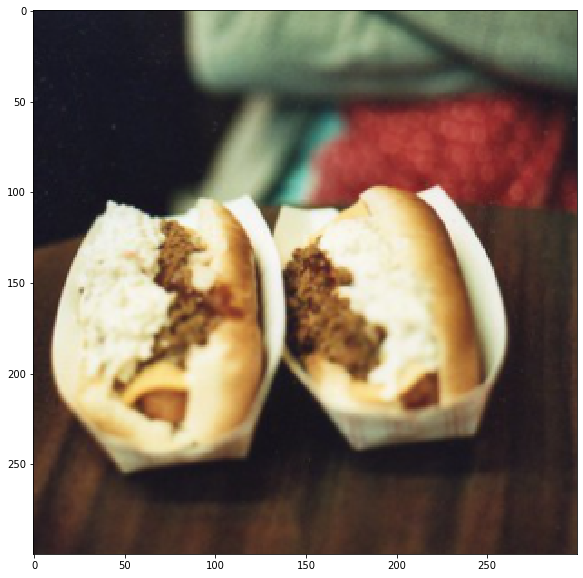

In [7]:
augment_and_show(aug, df['path'][1])

In [8]:
import os
from PIL import Image
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")


def smart_imread(x):
    xx = np.array(Image.open(x).convert("RGB"))
    return xx

def augment_small_classes(df):
    if not os.path.exists('./all_data/augmented'):
            os.makedirs('./all_data/augmented')
            os.makedirs('./all_data/augmented/only_hotdog')
            os.makedirs('./all_data/augmented/banana_n_hotdog')
            os.makedirs('./all_data/augmented/only_banana')
    
    counter = 0
    
    only_hotdog = df['path'][(df['hotdog'] == 1) & (df['banana'] == 0)].tolist()
    only_banana = df['path'][(df['hotdog'] == 0) & (df['banana'] == 1)].tolist()
    banana_n_hotdog = df['path'][(df['hotdog'] == 1) & (df['banana'] == 1)].tolist()
    
    size = len(df[(df['hotdog'] == 0) & (df['banana'] == 0)])
    
    resize = A.OneOf([
                        PercentageCrop(300, 300, always_apply=True, p=1),
                        A.Resize(300, 300, always_apply=True, p=1),
    ], p=1)
    
    tmp = zip(
        [
#             only_hotdog, 
            only_banana, 
            banana_n_hotdog
        ],
        [
#             'only_hotdog',
            'only_banana',
            'banana_n_hotdog'
        ]
    )
    
    for t, x in tmp:
        pathes = np.random.choice(
            t, 
            size=int(3 * (size - len(t)) / 4)
        )
        counter = 0
        for i, p in enumerate(tqdm(pathes)):
            new_path = os.path.join(
                os.path.join('./all_data/augmented', x),
                str(counter) + '.' + p.split('.')[-1]
            )
            image = smart_imread(p)
            h, w, c = image.shape
            if h > 2000 or w> 2000:
                image = resize(image=image)['image']
            image = aug(image=image)['image']
            imsave(
                new_path,
                image
            )
            counter += 1

In [9]:
augment_small_classes(df)

100%|██████████| 161223/161223 [3:44:44<00:00,  7.89it/s]   


In [1]:
from skimage.io import *
from glob import glob
from pathlib import Path
%matplotlib inline

def is_image(x):
    ext = x.split('.')[-1]
    accepted = {'jp', 'png', 'gif'}
    for a in accepted:
        if a in ext.lower():
            return True
    return False

In [14]:
import os
from tqdm import tqdm_notebook

def removeOtherFormats():
    paths = list(map(str, Path('./all_data').glob('**/*.*')))
    for path in tqdm_notebook(paths):
        if not is_image(path):
            os.remove(path)

In [15]:
removeOtherFormats()

In [16]:
paths = list(map(str, Path('./all_data').glob('**/*.*')))
len(paths)

701519

In [ ]:
# hotdog_s